In [146]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
from PIL import Image
import cv2

#url open to get image
import urllib.request
from urllib.request import urlopen

#get data in parallel
from multiprocessing import Pool

#plot (for image verification)
import matplotlib.cm as cm
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches

#access pdf data
from PyPDF2 import PdfFileWriter, PdfFileReader
from pdf2image import convert_from_path

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
path_data = os.path.join(ROOT_DIR,'datasets')

In [3]:
#contours approximation: https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html

In [ ]:
#The most common pixel format is the byte image, where this number is stored as an 8-bit integer giving a range of 
#possible values from 0 to 255. Typically zero is taken to be black, and 255 is taken to be white. Values in between 
#make up the different shades of gray.

# Download data

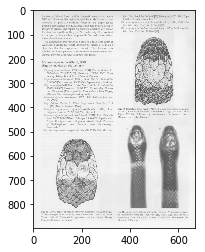

In [32]:
#scann book:
#os.path.join(path_data, 'image_book/scan/2004 The Venomous Reptiles of the Western Hemisphere I.pdf')
im = cv2.imread(os.path.join(path_data, 'image_book/scan/one_scan_image.png'))
#keep a copy of the original file
imCopy = im.copy()
plt.imshow(imCopy);

In [134]:
f = open(os.path.join(path_data, 'image_book/scan/2008 Snakes of India.pdf')
inputpdf = PdfFileReader(f, "rb"))
print('There is %d pages in the book'%inputpdf.numPages)

There is 241 pages in the book


In [154]:
f = os.path.join(path_data, 'image_book/scan/2008 Snakes of India.pdf')
pages = convert_from_path(f)

In [155]:
len(pages)

241

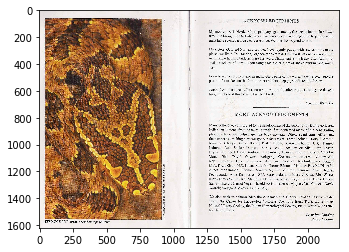

In [156]:
plt.imshow(pages[0]);

In [ ]:
for page in pages:
    page.save('out.jpg', 'JPEG')

In [159]:
def frompng2images(img, path, page_id=0, plot_=0):
    
    #some operation will directly impact the input image, so we must keep a copy of it
    imCopy = img.copy()
    
    ### convert to grayscale ###
    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ### find contour ###
    #for better accuracy we use binary images before finding contours, applying threshold: 
    #if pixel is above 200 (first value, reducing to 160 may lead to to much images) we assign 255 (second value), 
    #below we assign 0 (third value).
    ret,thresh = cv2.threshold(imgray,200,255,0)
    image, contours, hierarchy =  cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    #create a list of rectangle which may correspond to an image
    li_bbox = []
    for contour in contours:
        poly = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, False), False)
        x, y, w, h = cv2.boundingRect(poly)
        #remove if its really small compared to initial image (big enough height, big enough width &
        #not equal to inital img)
        hi, wi, ci = imCopy.shape
        if (h>(hi*0.1)) & (w>(wi*0.1)) & ((h!=hi) | (w!=wi)):
             li_bbox.append((x,y,w,h))
    
    if plot_==1:
        for bbox in li_bbox:
            x,y,w,h = bbox
            # Create figure and axes
            fig,ax = plt.subplots(1)
            # Display the image
            ax.imshow(imCopy)
            # Create a Rectangle patch
            rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)
            plt.show()
    
    #create directory if not existing
    if not os.path.exists(path):
        os.makedirs(path)
    
    #save
    for image_id,bbox in enumerate(li_bbox):
        x,y,w,h = bbox
        img_to_save = imCopy[y:y+h,x:x+w]
        img_to_save.save(os.path.join(path,'p'+str(page_id)+'_i'+str(image_id)+'.png'))        

        
        
def from_path_scannpdf_book_2image(path,path_save):
    pages = convert_from_path(path)
    print('There is %d page sin the book'%len(pages))
    for i,page in enumerate(pages):
        frompng2images(page, path=path_save, page_id=i)

In [160]:
book_title = '2008 Snakes of India.pdf'
from_path_scannpdf_book_2image(path=os.path.join(path_data, 'image_book/scan',book_title),
                        path_save=os.path.join(path_data, 'image_book/extracted_image/'+book_title.split('.')[0]))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/camille/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-160-4573def54151>", line 3, in <module>
    path_save=os.path.join(path_data, 'image_book/extracted_image/'+book_title.split('.')[0]))
  File "<ipython-input-159-35ffbb5aa0cf>", line 53, in from_path_scannpdf_book_2image
    pages = convert_from_path(path)
  File "/home/camille/anaconda3/lib/python3.6/site-packages/pdf2image/pdf2image.py", line 71, in convert_from_path
    images += parse_buffer_func(data)
  File "/home/camille/anaconda3/lib/python3.6/site-packages/pdf2image/pdf2image.py", line 137, in __parse_buffer_to_ppm
    images.append(Image.open(BytesIO(data[index:index + file_size])))
  File "/home/camille/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2572, in open
    im = _open_core(fp, filename, prefix)
  File "/home/camille/anaconda3/li

KeyboardInterrupt: 

# detect contour

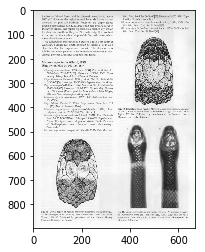

In [33]:
#convert to grayscale
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
plt.imshow(imgray,cmap='gray');

4362

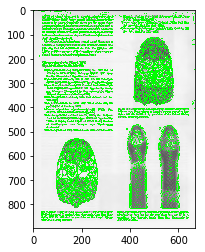

In [107]:
#For better accuracy we use binary images. So before finding contours, apply threshold: 
#if pixel is above 200 (first value, reducing to 160 may lead to to much images) we assign 255 (second value), 
#below we assign 0 (third value).
#0: black, 255: white
ret,thresh = cv2.threshold(imgray,200,255,0)
image, contours, hierarchy =  cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
img_test  = cv2.drawContours(imCopy,contours,-1,(0,255,0))
plt.imshow(img_test);
len(contours)

# contour approximation to boundingbox

In [108]:
#create a list of rectangle which may correspond to an image
li_bbox = []
for contour in contours:
    poly = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, False), False)
    x, y, w, h = cv2.boundingRect(poly)
    #remove if its really small compared to initial image (big enough height, big enough width &
    #not equal to inital img)
    hi, wi, ci = imCopy.shape
    if (h>(hi*0.1)) & (w>(wi*0.1)) & ((h!=hi) | (w!=wi)):
         li_bbox.append((x,y,w,h))
len(li_bbox)        

4

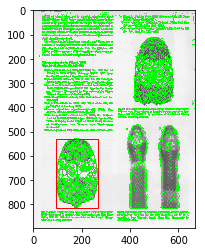

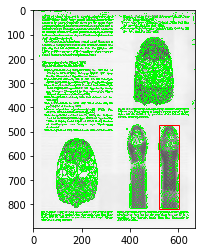

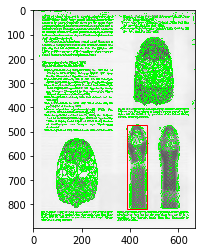

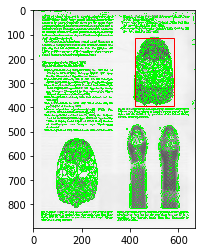

In [109]:
for bbox in li_bbox:
    x,y,w,h = bbox
    # Create figure and axes
    fig,ax = plt.subplots(1)
    # Display the image
    ax.imshow(imCopy)
    # Create a Rectangle patch
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()

# extract image from bbox

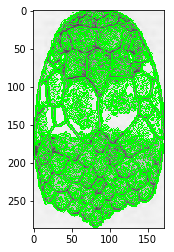

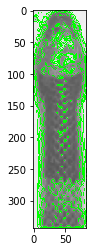

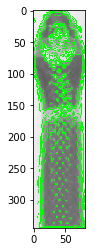

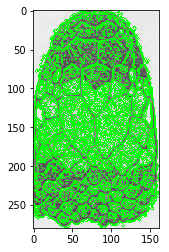

In [110]:
for bbox in li_bbox:
    x,y,w,h = bbox
    plt.imshow(imCopy[y:y+h,x:x+w])
    plt.show()